In [1]:
import os
import sys
from pathlib import Path
from pprint import pprint
import pickle
import time

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import seaborn as sns
import pandas as pd
import scipy
from sklearn.decomposition import PCA
from Bio import SeqIO
from Bio import Phylo

from interpretable_tsne.tsne import TSNE

os.chdir('..') # hacky
from src.helpers import make_cmap_labels

In [33]:
# SARS-CoV-2
def get_sars_data(run_id=0, data_id=0):

    grad_style = 'grad_norm'
    dset_name = 'mutlist01_del_over1'

    data_dir = '/scratch/sciclun4/data/Covid19/interpretable_tsne/{}'.format(dset_name)
    arr_obj_file = '{}/{}/processed_data.npz'.format(data_dir, data_id)
    arr_obj = np.load(arr_obj_file, allow_pickle=True)
    X_reduced = arr_obj['X_reduced']
    X = arr_obj['X_original']
    X_index = arr_obj['X_index']
    X_colnames = arr_obj['X_colnames']
    metadata_colnames = arr_obj['metadata_colnames']
    pca_comp = arr_obj['pca_comp']
    pca_mean = arr_obj['pca_mean']
    pca_obj = arr_obj['pca_obj'].item()

    results_dir = '/lustre07/scratch/sciclun4/results/interpretable_tsne/sarscov2/{}'.format(dset_name)
    results_dir = '{}/{}'.format(results_dir, run_id)
    arr_obj_res = np.load(Path(results_dir) / 'tsne_results_style={}.npz'.format(grad_style), allow_pickle=True)
    out = arr_obj_res['out'].item()
    emb = out['embeddings'][-1]

    metadata = pd.DataFrame(arr_obj['metadata'], columns=metadata_colnames)
    labels_who, cmap_who = make_cmap_labels(metadata['WHO Label'])
    
    return out['attrs'], labels_who, cmap_who, metadata['WHO Label']

def make_attr(pca_obj, attrs):
    # Get the loadings from the PCA object
    loadings = pca_obj.components_ * np.sqrt(pca_obj.explained_variance_).reshape(-1, 1)
    attr_recon = np.matmul(loadings.T, attrs.T).T
    return attr_recon

# Quality control
def get_qc_info(attrs):
    print('% of attrs >1: {:.2f}'.format((np.abs(attrs) > 1).mean()*100))
    print('% of NaN attrs: {:.2f}'.format(np.isnan(attrs).mean()))
    print('Largest attr: {}'.format(np.nanmax(np.abs(attrs))))
    print('% of attrs >10: {:.2f}'.format((np.abs(attrs) > 10).mean()*100))
    
def get_attrs_mnist(run_id):
    results_dir = '/scratch/sciclun4/results/interpretable_tsne/mnist/mnist/{}'.format(run_id)
    arr_obj_orig = np.load(Path(results_dir) / 'tsne_results_style=grad_norm.npz', allow_pickle=True)
    out = arr_obj_orig['out'].item()
    attrs = out['attrs']
    labels = np.load(arr_obj_orig['arr_obj_file'].item(), allow_pickle=True)['labels']
    return attrs, labels

def get_attrs_sim(data_seed=1, tsne_seed=0):
    # Synthetic Data
    df_name = 'Sim_4_Clusters_effect1=6_effect2=3'
    variable = 'Attr'
    data_dir = '/scratch/sciclun4/data/interpretable_tsne_sim_data'
    result_dir = '/lustre07/scratch/sciclun4/results/interpretable_tsne/interpretable_tsne_sim_data'
    arr_obj = np.load('{}/{}/{}/{}/tsne_results_style={}.npz'.format(result_dir, df_name, data_seed, tsne_seed, 'grad_norm'), allow_pickle=True)
    data_obj = np.load('{}/{}/{}/processed_data.npz'.format(data_dir, df_name, data_seed), 'rb')
    data, labels = data_obj['X_reduced'], data_obj['labels']
    emb = arr_obj['out'].item()['embeddings']
    out = arr_obj['out'].item()
    attrs_sim = out['attrs']
    return attrs_sim, labels

In [8]:
def make_stacked_barplot(df, _class, time_order=[1, 5, 25, 50, 125, 250, 500, 1000]):
    # Group the data by time and feat, and sum the attr column
    grouped_data = df[df['class']==_class].groupby(['time', 'feat']).sum().reset_index()

    # Pivot the data to create a wide-form DataFrame
    pivoted_data = grouped_data.pivot(index='time', columns='feat', values='attr').fillna(0)

    # Reorder the columns of the pivoted DataFrame to match the order of the feat values
    pivoted_data = pivoted_data.reindex(sorted(pivoted_data.columns), axis=1)

    # Create the stacked barplot using seaborn
    sns.set_style('whitegrid')
    ax = pivoted_data.plot(kind='bar',
                           stacked=True,
                           width=1,
                           edgecolor='none')

    # Set the x-axis labels to the time categories
    ax.set_xticks([50, 100, 150, 200, 250, 300, 350, 400])
    ax.set_xticklabels([50, 100, 150, 200, 250, 300, 350, 400])
    #ax.set_xticklabels(time_order)

    # Set the axis labels and title
    ax.set_xlabel('Time')
    ax.set_ylabel('Attr')
    ax.set_title('Stacked Barplot')

    # Move the legend outside of the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.show()

def make_attrs_df(attrs_full, labels, attr_idx, times=[1,5,25,50,125,250,500,1000]):

    #attrs_full = np.stack(attrs_full)
    attrs_full = np.expand_dims(np.stack(attrs_full).mean(1), 1) # avg out x,y dimensions

    attrs_full = attrs_full[:,attr_idx,:,:]
    attrs_full[np.isnan(attrs_full)] = 0
    attrs_full[attrs_full < -1] = -1
    attrs_full[attrs_full > 1] = 1

    df = pd.DataFrame({'attr':[], 'feat': [], 'class': [], 'time': []})
    for time in times:
        _attrs = attrs_full[time]
        for label in np.unique(labels):
            _attrs2 = _attrs[labels == label]
            tot = np.abs(_attrs2).mean(0).sum()
            for feat in range(10):
                _attrs_feat = np.abs(_attrs2[:,feat]).mean()/tot
                df = pd.concat([df, pd.DataFrame({'attr': _attrs_feat, 'feat': feat, 'class': label, 'time': time}, index=[0])])
    df['feat'] = pd.Categorical(df['feat']+1)
    return df

In [34]:
attrs_sars, labels_who, cmap_who, labels_sars = get_sars_data()
attrs_mnist, labels_mnist = get_attrs_mnist(20)
attrs_sim, labels_sim = get_attrs_sim()

In [6]:
attrs_sars250 = attrs_sars[250][0]
get_qc_info(attrs_sars250)

attrs_mnist_250 = attrs_mnist[250][0]
get_qc_info(attrs_mnist_250)

attrs_sim_250 = attrs_sim[250][0]
get_qc_info(attrs_sim_250)

% of attrs >1: 1.07
% of NaN attrs: 0.00
Largest attr: 9.651105103407177e+28
% of attrs >10: 0.09
% of attrs >1: 0.36
% of NaN attrs: 0.00
Largest attr: inf
% of attrs >10: 0.19
% of attrs >1: 0.10
% of NaN attrs: 0.00
Largest attr: 41.8925895690918
% of attrs >10: 0.03


## Attributions Over Time

In [10]:
df_mnist = make_attrs_df(attrs_mnist, labels_mnist, 0, np.arange(500))

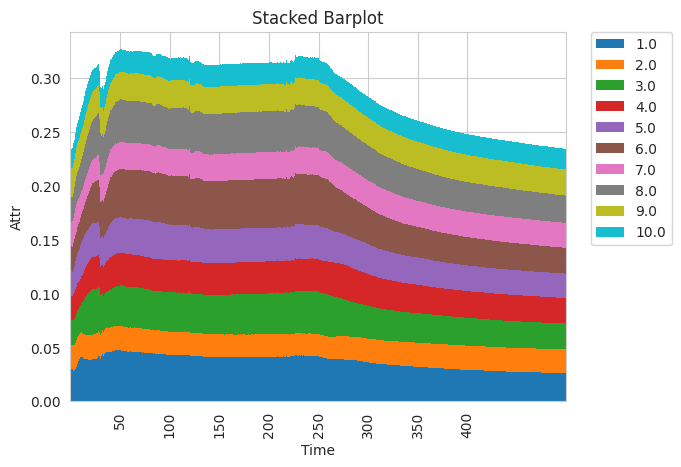

In [22]:
make_stacked_barplot(df_mnist, '0', np.arange(500))

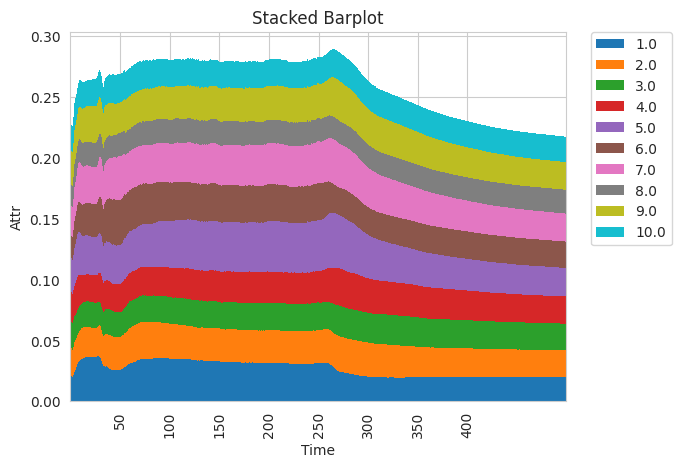

In [21]:
make_stacked_barplot(df_mnist, '1', np.arange(500))

In [13]:
df_sim = make_attrs_df(attrs_sim, labels_sim, 0, np.arange(500))

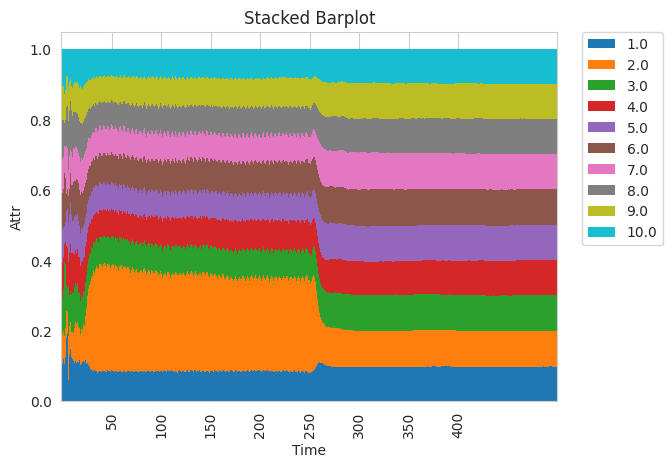

In [17]:
make_stacked_barplot(df_sim, 0, np.arange(500))

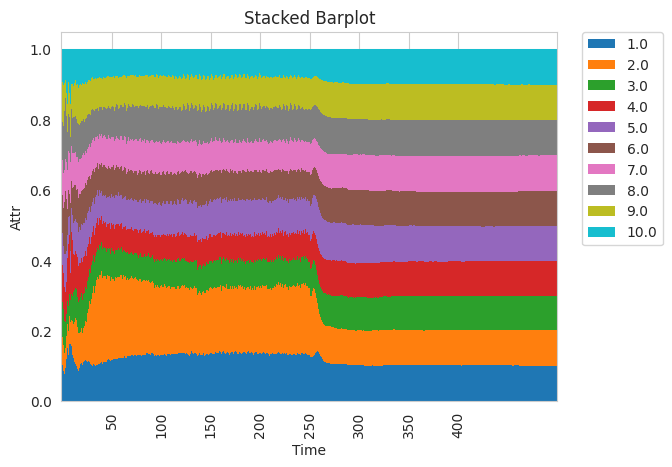

In [18]:
make_stacked_barplot(df_sim, 1, np.arange(500))

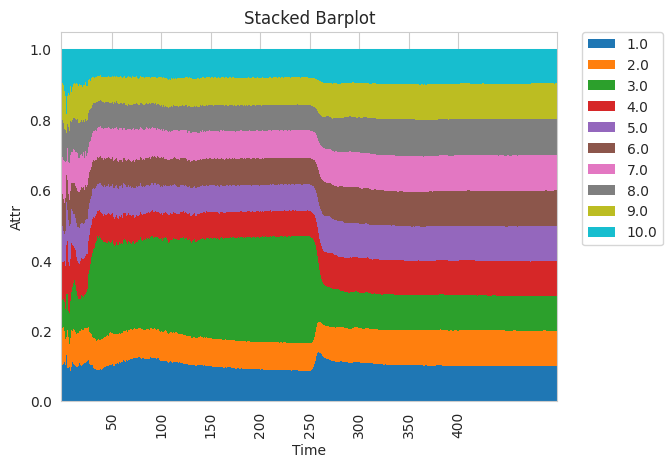

In [19]:
make_stacked_barplot(df_sim, 2, np.arange(500))

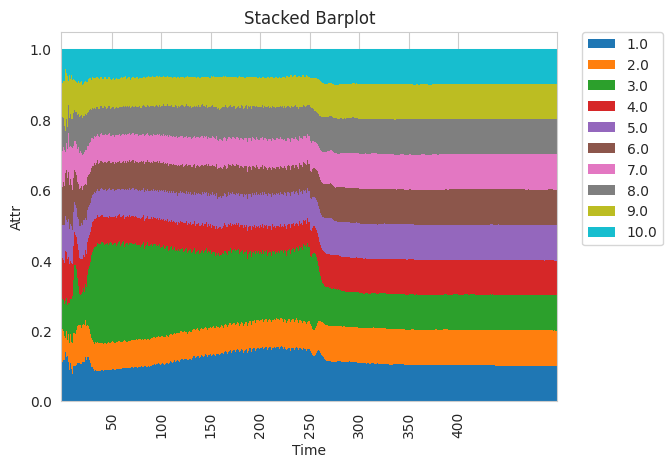

In [20]:
make_stacked_barplot(df_sim, 3, np.arange(500))

In [39]:
df_sars = make_attrs_df(attrs_sars, labels_sars, 0, np.arange(500))

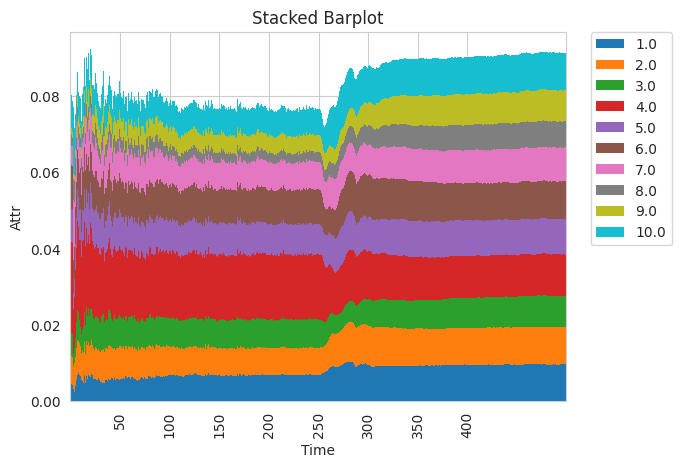

In [40]:
make_stacked_barplot(df_sars, 'Alpha', np.arange(500))

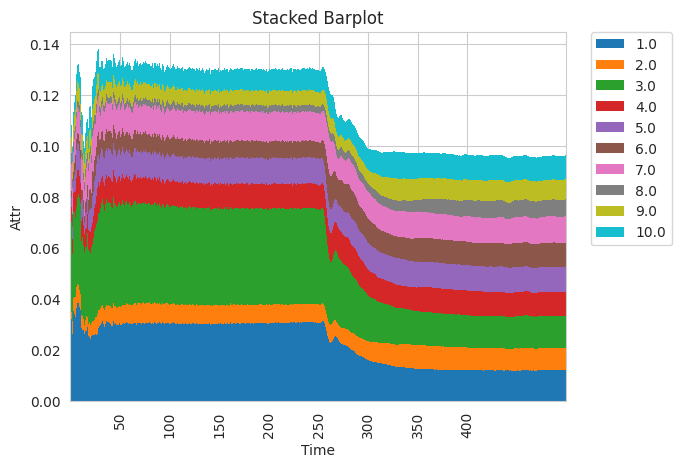

In [41]:
make_stacked_barplot(df_sars, 'Omicron BA.1', np.arange(500))